In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import math
from datetime import datetime
from datetime import timedelta
import pytz

path = '/Users/artemilin/Downloads/data'

In [3]:
companies_of_choice = ['AAPL.csv',  ## Apple
                       'AMZN.csv',  ## Amazon
                       'FB.csv',  ## Facebook (now META)
                       'GOOGL.csv',  ## Google Alphabet Inc.
                       'MSFT.csv',  ## Microsoft
                       'NFLX.csv',  ## Netflix
                       'NVDA.csv',  ## Nvidia
                       'TSLA.csv'  ## Tesla
                       ]

In [4]:
all_dfs = []
shapes_of_tickers_dfs = {}

for ticker in companies_of_choice:
    dirs = []
    for year in ['2017', '2018', '2019', '2021']:
        dirs.append(f'{path}/{year}/{ticker}')

    df_ticker = pd.concat(
        map(pd.read_csv, dirs), ignore_index=True)
    #df_ticker['date'] = pd.to_datetime(df_ticker['date'])
    shapes_of_tickers_dfs[ticker] = df_ticker.shape

    all_dfs.append(df_ticker.add_prefix(f'{ticker.split(".")[0]}_'))

df0 = pd.concat(all_dfs, axis=1)

In [83]:
df0.head()

,AAPL_date,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_volume,AAPL_vwap,AAPL_timestamp,AAPL_transactions,AAPL_otc,...,TSLA_date,TSLA_open,TSLA_high,TSLA_low,TSLA_close,TSLA_volume,TSLA_vwap,TSLA_timestamp,TSLA_transactions,TSLA_otc
0,2017-01-03 09:30:00-05:00,28.9500,28.9750,28.8750,28.9713,3851984.0,28.9422,1483453800000,1970.0,NaN,...,2017-01-03 09:30:00-05:00,14.3240,14.3533,14.2800,14.2840,1360425.0,14.3219,1.483454e+12,367.0,NaN
1,2017-01-03 09:31:00-05:00,28.9750,29.0625,28.9475,29.0622,997416.0,29.0088,1483453860000,1050.0,NaN,...,2017-01-03 09:31:00-05:00,14.2800,14.2987,14.2500,14.2500,756270.0,14.2741,1.483454e+12,497.0,NaN
2,2017-01-03 09:32:00-05:00,29.0625,29.0825,29.0575,29.0750,653408.0,29.0686,1483453920000,700.0,NaN,...,2017-01-03 09:32:00-05:00,14.2500,14.2500,14.1720,14.1893,702690.0,14.2128,1.483454e+12,550.0,NaN
3,2017-01-03 09:33:00-05:00,29.0750,29.0750,29.0050,29.0276,1005592.0,29.0285,1483453980000,1049.0,NaN,...,2017-01-03 09:33:00-05:00,14.1853,14.2020,14.0913,14.1000,1084935.0,14.1462,1.483454e+12,599.0,NaN
4,2017-01-03 09:34:00-05:00,29.0273,29.0600,29.0273,29.0375,667760.0,29.0412,1483454040000,929.0,NaN,...,2017-01-03 09:34:00-05:00,14.0933,14.1253,14.0640,14.1193,1251645.0,14.0868,1.483454e+12,689.0,NaN


In [5]:
df_AAPL = df0[['AAPL_date', 'AAPL_open', 'AAPL_high', 'AAPL_low', 'AAPL_close', 'AAPL_volume', 'AAPL_vwap',
              'AAPL_transactions']]  # 'AAPL_timestamp',

df_AAPL = df_AAPL.rename(columns={"AAPL_date": "date",
                                  "AAPL_open": "open",
                                  "AAPL_high": "high",
                                  "AAPL_low": "low",
                                  "AAPL_close": "close",
                                  "AAPL_volume": "volume",
                                  "AAPL_vwap": "vwap",
                                  "AAPL_transactions": "transactions"
                                  })

df_AAPL['date'] = pd.to_datetime(df_AAPL['date'], format="%Y-%m-%d %H:%M:%S", utc=True)
df_AAPL = df_AAPL.set_index(pd.DatetimeIndex(df_AAPL['date']))

In [85]:
day_df = df_AAPL.resample('1D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'})
day_df = day_df[~day_df['close'].isna()]

In [58]:
day_df.head()

,open,high,low,close,volume
date,,,,,
2017-01-03 00:00:00+00:00,28.9500,29.0825,28.6900,29.0225,102572716.0
2017-01-04 00:00:00+00:00,28.9625,29.1275,28.9375,29.0025,74946512.0
2017-01-05 00:00:00+00:00,28.9800,29.2161,28.9525,29.1525,83368768.0
2017-01-06 00:00:00+00:00,29.1950,29.5400,29.1175,29.4925,116451676.0
2017-01-09 00:00:00+00:00,29.4875,29.8575,29.4850,29.7450,122837968.0


In [6]:
df_AAPL['log_price'] = np.log(df_AAPL['close'])

In [7]:
df_AAPL["rets"] = df_AAPL["close"].pct_change()

In [8]:
vols = df_AAPL["rets"].rolling(60).std(ddof=0)
df_AAPL['r_vol'] = pd.DataFrame(vols)
df_AAPL['r_vol'].fillna((df_AAPL['r_vol'].mean()), inplace=True)

In [9]:
df_AAPL = df_AAPL.iloc[1:]

In [16]:
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index,
       the previous peaks, and
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series/100).cumprod()
    previous_peaks = np.log(wealth_index.cummax())
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index,
                         "Previous Peak": previous_peaks,
                         "Drawdown": drawdowns})

drawdown(df_AAPL['close'])["Previous Peak"] - Becomes inf => drawdowns besomes 0 and NaNs, don't try this at home

In [63]:
df_AAPL.head()

,date,open,high,low,close,volume,vwap,transactions,log_price,rets,r_vol
date,,,,,,,,,,,
2017-01-03 14:31:00+00:00,2017-01-03 14:31:00+00:00,28.9750,29.0625,28.9475,29.0622,997416.0,29.0088,1050.0,3.369438,0.003138,0.000677
2017-01-03 14:32:00+00:00,2017-01-03 14:32:00+00:00,29.0625,29.0825,29.0575,29.0750,653408.0,29.0686,700.0,3.369879,0.000440,0.000677
2017-01-03 14:33:00+00:00,2017-01-03 14:33:00+00:00,29.0750,29.0750,29.0050,29.0276,1005592.0,29.0285,1049.0,3.368247,-0.001630,0.000677
2017-01-03 14:34:00+00:00,2017-01-03 14:34:00+00:00,29.0273,29.0600,29.0273,29.0375,667760.0,29.0412,929.0,3.368588,0.000341,0.000677
2017-01-03 14:35:00+00:00,2017-01-03 14:35:00+00:00,29.0375,29.0625,29.0200,29.0375,779004.0,29.0435,1434.0,3.368588,0.000000,0.000677


In [10]:
df_AAPL = df_AAPL.dropna()
df_AAPL["OBV"] = (np.sign(df_AAPL["close"].diff()) * df_AAPL["volume"]).fillna(0).cumsum()

In [11]:
exp1 = df_AAPL['close'].ewm(span=12, adjust=False).mean()
exp2 = df_AAPL['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
df_AAPL['MACD'] = macd

In [14]:
def compute_volume_bars(df, volume_bar_size):
    cumsum_vol = df['volume'].cumsum()/volume_bar_size
    max_tick = int(cumsum_vol.max())
    ticks = pd.Series(range(max_tick))
    return cumsum_vol.searchsorted(ticks)

In [ ]:
# df_AAPL['volume_bars'] = compute_volume_bars(df_AAPL, 4)

In [ ]:
def compute_dollar_bars(df, dollar_bar_size):
    '''
        Compute indexes of dollar bars, indexes represented as integers,
        data can be fetched by df.iloc[idxs]
    '''
    if 'vwap' in df.columns:
        dollars = df['volume'] * df['vwap']
    else:
        dollars = (df['close'] + df['open'])/2 * df['volume']
    dollars = dollars.cumsum()/dollar_bar_size
    max_tick = int(dollars.max())
    ticks = pd.Series(range(max_tick))
    return dollars.searchsorted(ticks)

In [ ]:
## df_AAPL['dollar_bars'] = compute_dollar_bars(df_AAPL, 4)

In [12]:
def rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [13]:
df_AAPL['rsi'] = rsi(df_AAPL, periods = 60, ema = True)

In [14]:
df_AAPL = df_AAPL.apply(lambda x: x.fillna(x.mean()),axis=0)

In [15]:
def bollinger_bands(df, n=60, m=60):
    # takes dataframe on input
    # n = smoothing length
    # m = number of standard deviations away from MA

    #typical price
    TP = (df['high'] + df['low'] + df['close']) / 3
    # but we will use Adj close instead for now, depends

    data = TP
    #data = df['Adj Close']

    # takes one column from dataframe
    B_MA = pd.Series((data.rolling(n, min_periods=n).mean()), name='B_MA')
    sigma = data.rolling(n, min_periods=n).std()

    BU = pd.Series((B_MA + m * sigma), name='BU')
    BL = pd.Series((B_MA - m * sigma), name='BL')

    df = df.join(B_MA)
    df = df.join(BU)
    df = df.join(BL)

    return df

In [16]:
df_AAPL = bollinger_bands(df_AAPL)

In [17]:
df_AAPL = df_AAPL.apply(lambda x: x.fillna(x.mean()), axis=0)

In [18]:
df_AAPL

,date,open,high,low,close,volume,vwap,transactions,log_price,rets,r_vol,OBV,MACD,rsi,B_MA,BU,BL
date,,,,,,,,,,,,,,,,,
2017-01-03 14:31:00+00:00,2017-01-03 14:31:00+00:00,28.9750,29.0625,28.9475,29.0622,997416.0,29.0088,1050.0,3.369438,0.003138,0.000677,0.000000e+00,0.000000,50.775145,57.951917,65.468024,50.435810
2017-01-03 14:32:00+00:00,2017-01-03 14:32:00+00:00,29.0625,29.0825,29.0575,29.0750,653408.0,29.0686,700.0,3.369879,0.000440,0.000677,6.534080e+05,0.001021,50.775145,57.951917,65.468024,50.435810
2017-01-03 14:33:00+00:00,2017-01-03 14:33:00+00:00,29.0750,29.0750,29.0050,29.0276,1005592.0,29.0285,1049.0,3.368247,-0.001630,0.000677,-3.521840e+05,-0.001972,50.775145,57.951917,65.468024,50.435810
2017-01-03 14:34:00+00:00,2017-01-03 14:34:00+00:00,29.0273,29.0600,29.0273,29.0375,667760.0,29.0412,929.0,3.368588,0.000341,0.000677,3.155760e+05,-0.003504,50.775145,57.951917,65.468024,50.435810
2017-01-03 14:35:00+00:00,2017-01-03 14:35:00+00:00,29.0375,29.0625,29.0200,29.0375,779004.0,29.0435,1434.0,3.368588,0.000000,0.000677,3.155760e+05,-0.004665,50.775145,57.951917,65.468024,50.435810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 20:56:00+00:00,2020-12-31 20:56:00+00:00,132.6500,132.8200,132.6500,132.7693,513816.0,132.7459,3191.0,4.888613,0.000975,0.000944,2.448501e+09,0.009497,49.985376,132.860787,142.346972,123.374601
2020-12-31 20:57:00+00:00,2020-12-31 20:57:00+00:00,132.7700,132.9200,132.7600,132.8408,505929.0,132.8310,3527.0,4.889151,0.000539,0.000946,2.449007e+09,0.010779,50.856946,132.858958,142.320223,123.397693
2020-12-31 20:58:00+00:00,2020-12-31 20:58:00+00:00,132.8400,132.9200,132.8300,132.8600,517398.0,132.8745,3472.0,4.889296,0.000145,0.000946,2.449525e+09,0.013192,51.089702,132.857902,142.301491,123.414314


In [21]:
df_AAPL.to_csv('AAPLFeatures.csv', index=False)

data is created

In [3]:
df = pd.read_csv('AAPLFeatures.csv').drop(columns=['open', 'high', 'low', 'OBV', 'BU', 'BL'])

In [86]:
df.head()

,date,close,volume,vwap,transactions,log_price,rets,r_vol,MACD,rsi,B_MA
0,2017-01-03 14:31:00+00:00,29.0622,997416.0,29.0088,1050.0,3.369438,0.003138,0.000677,0.000000,50.775145,57.951917
1,2017-01-03 14:32:00+00:00,29.0750,653408.0,29.0686,700.0,3.369879,0.000440,0.000677,0.001021,50.775145,57.951917
2,2017-01-03 14:33:00+00:00,29.0276,1005592.0,29.0285,1049.0,3.368247,-0.001630,0.000677,-0.001972,50.775145,57.951917
3,2017-01-03 14:34:00+00:00,29.0375,667760.0,29.0412,929.0,3.368588,0.000341,0.000677,-0.003504,50.775145,57.951917
4,2017-01-03 14:35:00+00:00,29.0375,779004.0,29.0435,1434.0,3.368588,0.000000,0.000677,-0.004665,50.775145,57.951917


Text(0, 0.5, '$Price')

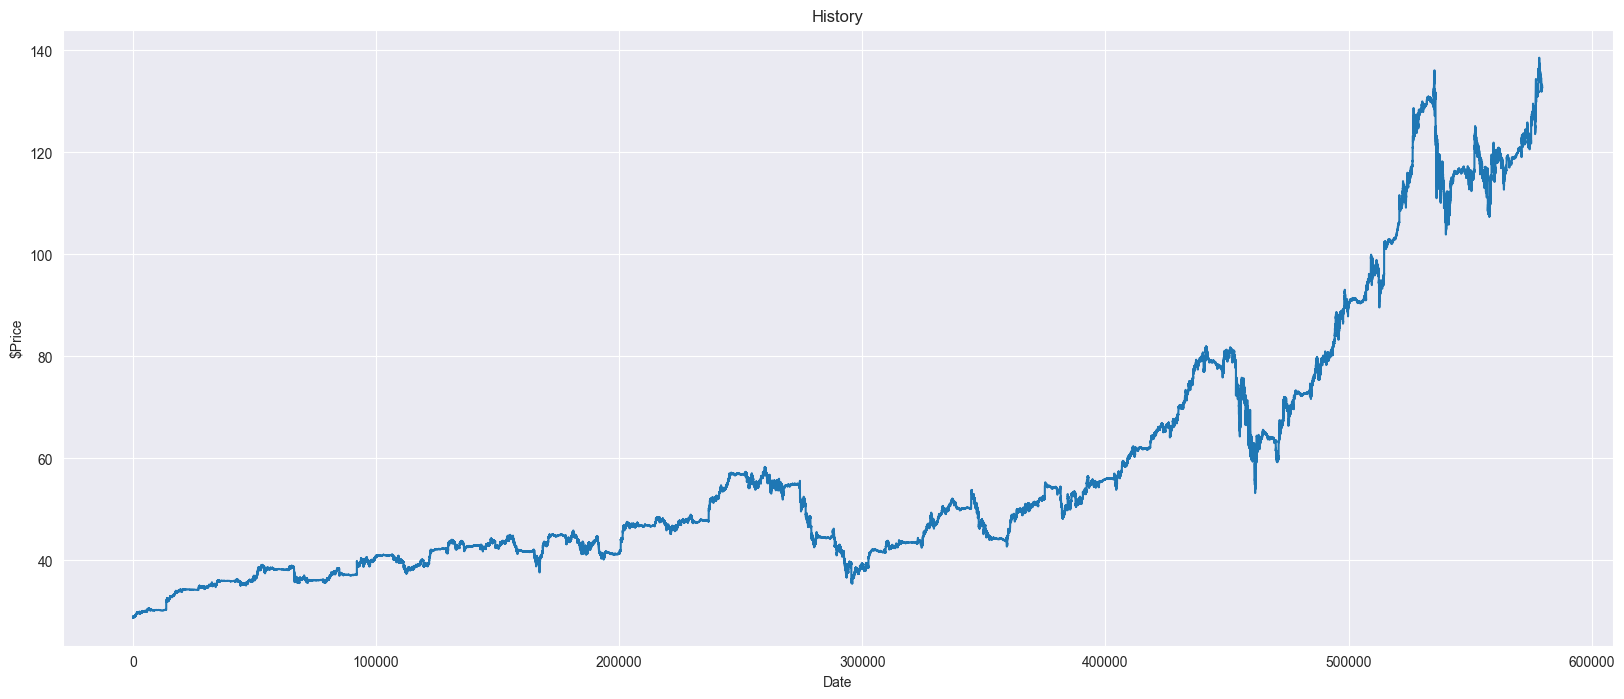

In [92]:
plt.figure(figsize=(20, 8))
plt.title('History')
plt.plot(df[['close']])
plt.xlabel('Date')
plt.ylabel('$Price')

https://stackoverflow.com/questions/54544285/is-it-possible-to-do-multivariate-multi-step-forecasting-using-fb-prophet

In [16]:
slice_df = df[(df['date'] > "2017-01-03 09:30:00") & (df['date'] < "2018-01-03 09:30:00")]
slice_df = slice_df.rename(columns={"date": "ds", "close": "y"})
slice_df['ds'] = pd.to_datetime(slice_df['ds'])
slice_df['ds'] = slice_df['ds'].dt.tz_localize(None)

In [146]:
for i in range(slice_df.shape[0]):
    slice_df['ds'][i] = datetime.strptime(slice_df['ds'][i][:19], '%Y-%m-%d %H:%M:%S')

/var/folders/xd/xm863f553v750zss70sl77sc0000gn/T/ipykernel_3647/95069502.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice_df['ds'][i] = datetime.strptime(slice_df['ds'][i][:19], '%Y-%m-%d %H:%M:%S')


In [8]:
slice_df['ds']

0        2017-01-03 14:31:00+00:00
1        2017-01-03 14:32:00+00:00
2        2017-01-03 14:33:00+00:00
3        2017-01-03 14:34:00+00:00
4        2017-01-03 14:35:00+00:00
                    ...           
150951   2018-01-02 20:56:00+00:00
150952   2018-01-02 20:57:00+00:00
150953   2018-01-02 20:58:00+00:00
150954   2018-01-02 20:59:00+00:00
150955   2018-01-02 21:00:00+00:00
Name: ds, Length: 150956, dtype: datetime64[ns, UTC]

In [129]:
#slice_df['ds'] = slice_df['ds'] .dt.tz_localize(None)

AttributeError: Can only use .dt accessor with datetimelike values

In [9]:
str(slice_df["ds"][0])

'2017-01-03 14:31:00+00:00'

In [17]:
df_train = slice_df.loc[slice_df["ds"] < "2017-09-01 09:30:00"]
df_test  = slice_df.loc[ slice_df["ds"] >= "2017-09-01 09:30:00"]

In [18]:
print(df_train.shape)
print(df_test.shape)

(106561, 11)
(44395, 11)


In [12]:
df_test.columns

Index(['ds', 'y', 'volume', 'vwap', 'transactions', 'log_price', 'rets',
       'r_vol', 'MACD', 'rsi', 'B_MA'],
      dtype='object')

In [13]:
#slice_df['ds'] = pd.to_datetime(slice_df['ds'] , format='%d/%m/%y %H:%M:%S').dt.strftime('%Y-%m-%d %H:%M:%S')

In [19]:
from fbprophet import Prophet
m = Prophet(changepoint_prior_scale=0.01)
for feature in ['volume', 'vwap', 'transactions', 'log_price', 'rets', 'r_vol', 'MACD', 'rsi', 'B_MA']:
    m.add_regressor(feature)

In [20]:
m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/artemilin/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -107.424
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        609074    0.00323594   2.84142e+06           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        635531   0.000166786   1.37823e+06           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        643861   0.000436782        623969           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        655740   0.000823617   2.69069e+06      0.6054      0.6054      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        674569   0.000132571   1.09581e+06      0.8145      0.8145      543   
    Iter      log prob        ||dx||      ||grad||       alpha  

   3399        786709    0.00248616   1.67879e+07      0.4333           1     3661   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    3499        795639   7.77713e-05   3.86783e+06           1           1     3765   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    3599        797892   7.40299e-05   1.69466e+06           1           1     3874   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    3699        798096   1.47349e-05   1.00132e+06           1           1     3980   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    3799        798687   1.42764e-05   2.67992e+06      0.2001      0.2001     4095   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    3899        800276   9.10367e-05   7.22847e+06           1           1     4200   
    Iter      log p

In [21]:
# Python
from fbprophet.serialize import model_to_json, model_from_json

with open('fbprophetAAPL.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

#with open('serialized_model.json', 'r') as fin:
#    m = model_from_json(fin.read())  # Load model

In [ ]:
"""model.compile(optimizer='adam', loss='mean_absolute_percentage_error')  ###
model.fit(x_train, y_train, batch_size=1, epochs=3)"""

In [26]:
future = m.make_future_dataframe(periods = 365)

for col in ['volume', 'vwap', 'transactions', 'log_price', 'rets', 'r_vol', 'MACD', 'rsi', 'B_MA']:
    future[col] = np.nan

future.tail()

,ds,volume,vwap,transactions,log_price,rets,r_vol,MACD,rsi,B_MA
65866,2018-08-27 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65867,2018-08-28 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65868,2018-08-29 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65869,2018-08-30 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65870,2018-08-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
forecast = m.predict(df_test.drop(columns=['y']))

/Users/artemilin/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/artemilin/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [37]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,B_MA,B_MA_lower,B_MA_upper,MACD,...,vwap,vwap_lower,vwap_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-09-01 13:30:00,34.485012,41.207442,41.231612,34.485012,34.485012,0.000845,0.000845,0.000845,-0.000008,...,4.936752,4.936752,4.936752,-0.002179,-0.002179,-0.002179,0.0,0.0,0.0,41.218886
1,2017-09-01 13:31:00,34.485013,41.184463,41.209577,34.485013,34.485013,0.000845,0.000845,0.000845,-0.000114,...,4.945083,4.945083,4.945083,-0.002178,-0.002178,-0.002178,0.0,0.0,0.0,41.196549
2,2017-09-01 13:32:00,34.485013,41.183296,41.209952,34.485013,34.485013,0.000846,0.000846,0.000846,-0.000233,...,4.934670,4.934670,4.934670,-0.002177,-0.002177,-0.002177,0.0,0.0,0.0,41.196680
3,2017-09-01 13:33:00,34.485013,41.190984,41.215452,34.485013,34.485013,0.000846,0.000846,0.000846,-0.000307,...,4.957200,4.957200,4.957200,-0.002176,-0.002176,-0.002176,0.0,0.0,0.0,41.203494
4,2017-09-01 13:34:00,34.485013,41.170018,41.195051,34.485013,34.485013,0.000847,0.000847,0.000847,-0.000337,...,4.940539,4.940539,4.940539,-0.002176,-0.002176,-0.002176,0.0,0.0,0.0,41.183648


In [38]:
forecast = forecast.set_index(pd.DatetimeIndex(forecast['ds']))

In [40]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,B_MA,B_MA_lower,B_MA_upper,MACD,...,vwap,vwap_lower,vwap_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2017-09-01 13:30:00,2017-09-01 13:30:00,34.485012,41.207442,41.231612,34.485012,34.485012,0.000845,0.000845,0.000845,-0.000008,...,4.936752,4.936752,4.936752,-0.002179,-0.002179,-0.002179,0.0,0.0,0.0,41.218886
2017-09-01 13:31:00,2017-09-01 13:31:00,34.485013,41.184463,41.209577,34.485013,34.485013,0.000845,0.000845,0.000845,-0.000114,...,4.945083,4.945083,4.945083,-0.002178,-0.002178,-0.002178,0.0,0.0,0.0,41.196549
2017-09-01 13:32:00,2017-09-01 13:32:00,34.485013,41.183296,41.209952,34.485013,34.485013,0.000846,0.000846,0.000846,-0.000233,...,4.934670,4.934670,4.934670,-0.002177,-0.002177,-0.002177,0.0,0.0,0.0,41.196680
2017-09-01 13:33:00,2017-09-01 13:33:00,34.485013,41.190984,41.215452,34.485013,34.485013,0.000846,0.000846,0.000846,-0.000307,...,4.957200,4.957200,4.957200,-0.002176,-0.002176,-0.002176,0.0,0.0,0.0,41.203494
2017-09-01 13:34:00,2017-09-01 13:34:00,34.485013,41.170018,41.195051,34.485013,34.485013,0.000847,0.000847,0.000847,-0.000337,...,4.940539,4.940539,4.940539,-0.002176,-0.002176,-0.002176,0.0,0.0,0.0,41.183648


In [42]:
df_test = df_test.set_index(pd.DatetimeIndex(df_test['ds']))

<AxesSubplot:>

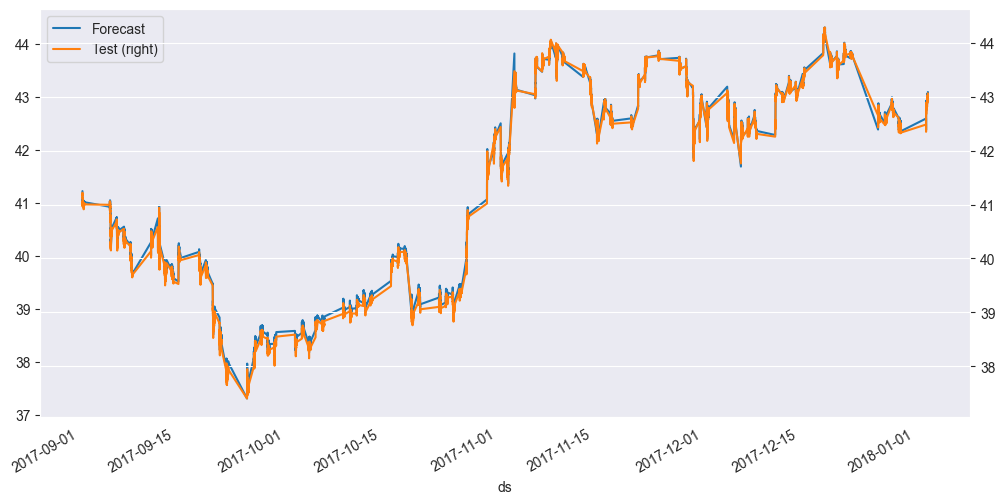

In [45]:
forecast['yhat'].plot(label="Forecast", figsize=(12,6), legend=True)
df_test['y'].plot(label="Test", legend=True, secondary_y=True)

In [46]:
from sklearn.metrics import mean_absolute_percentage_error
print(f'MAPE: {mean_absolute_percentage_error(df_test.y, forecast.yhat)}')

MAPE: 0.0004915016486198822
